# Make new Product Recommendations

# Problem Statement -
Build your own recommendation system for products on an e-commerce website like Amazon.com.

Dataset: Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) ratings_Electronics_Ver3.tar.xz (you may use winrar application to extract the .csv file)

Dataset columns - first three columns are userId, productId, and ratings and the fourth column is timestamp. 

You can discard the timestamp column as in this case you may not need to use it.
The repository has several datasets. For this case study, please use the Electronics dataset.
The host page has several pointers to scripts and other examples that can help with parsing the datasets.
The data set consists of:
 - 7,824,482 Ratings (1-5) for Electronics products.
 - Other metadata about products. 

Please see the description of the fields available on the web page cited above.

# Mark Distributions -
Step - 1,2,3,8 - 5 marks each

Step - 4,5,6,7 - 10 marks each

# 1. Read and explore the dataset. (Rename column, plot histograms, find data characteristics)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#Loading data
#Read the CSV file and prepare the DF
#For convenience of future use, parse the raw data file (using Python, for example) and 
#extract the following fields: 'product/productId' as prod_id, 'product/title' as prod_name, 
#'review/userId' as user id, 'review/score' as rating

data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ratings_Electronics.csv", skiprows=1, names=['user_id', 'product_id', 'rating', 'timestamp'])
data.sample(5)

,user_id,product_id,rating,timestamp
5775512,A1O8NIXQ32DXAS,B007JF861O,3.0,1353456000
3914963,A1DLOJ2ONEJJUR,B0046TAAY2,5.0,1346716800
4895524,ANW6EGY12V5XS,B005EWB3AU,4.0,1320796800
2517689,A1C6R5WYNHDH03,B002BET3FG,5.0,1316131200
5799088,A3F8P7IFY43GJM,B007LBOCVY,5.0,1354924800


In [23]:
#For now Timestamp appearing to unrelevant field for rocomendation otherwise it can be one of the crucial element in determing:
# Most popular products in certain time frames like (latest, last weeks, last month etc.)

data.drop('timestamp', axis=1, inplace=True)

In [24]:
data.dtypes

user_id        object
product_id     object
rating        float64
dtype: object

In [25]:
data.nunique()

user_id       4201696
product_id     476001
rating              5
dtype: int64

In [26]:
data.rating.unique()

array([5., 1., 3., 2., 4.])

In [27]:
data.shape

(7824481, 3)

In [30]:
# Count total percentage of null values
data.isnull().sum()/data.isnull().count()*100

user_id       0.0
product_id    0.0
rating        0.0
dtype: float64

In [32]:
data.drop(data[data.isna().any(axis=1)].index, inplace=True)

5.0    55.563302
4.0    18.988876
1.0    11.524918
3.0     8.090926
2.0     5.831978
Name: rating, dtype: float64


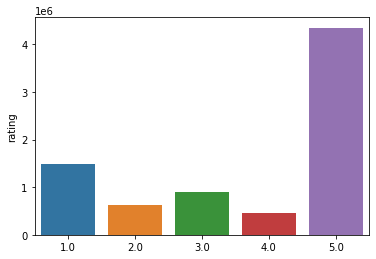

In [33]:
print((100*data['rating'].value_counts()/data['rating'].value_counts().sum()))
sns.barplot(x = data['rating'].unique(), y=data['rating'].value_counts())
plt.show()

Rating 5 is the most common rating value and is appearing more than 55%

# 2. Take subset of dataset to make it less sparse/more dense. (For example, keep the users only who has given 50 or more number of ratings )

In [35]:
print("Number of users rated more than 50 times", (data['user_id'].value_counts()>=50).sum())

Number of users rated more than 50 times 1540


In [36]:
#Get the count per user
user_rating_count = pd.DataFrame((data.groupby('user_id').count().reset_index()[['user_id', 'rating']]))
user_rating_count.columns=['user_id', 'rating_count']

In [39]:
#get users who have reviewerd more than threshold ratings
#filter the users data and ratings data for users lesser than the threshold rating count

user_rating_count = user_rating_count[user_rating_count['rating_count'] >= 50]
print(user_rating_count.rating_count.sum(), "records to be considered for further evaluation for", user_rating_count.user_id.count(), "products")

125871 records to be considered for further evaluation for 1540 products


In [40]:
data_filtered = data[data['user_id'].isin(user_rating_count['user_id'])]
data_filtered.shape

(125871, 3)

In [41]:
data_filtered['rating'] = data_filtered['rating'].apply(pd.to_numeric)

5.0    56.433968
4.0    25.657220
3.0     9.581238
2.0     4.263889
1.0     4.063684
Name: rating, dtype: float64


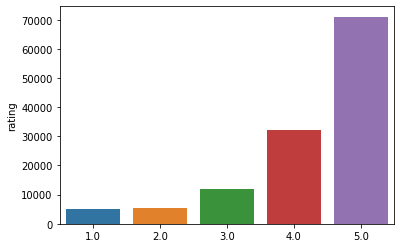

In [42]:
print((100*data_filtered['rating'].value_counts())/data_filtered['rating'].count())
sns.barplot(x = data_filtered['rating'].value_counts().index, y=data_filtered['rating'].value_counts())
plt.show()

Number of ratings have increased for rating values 4 & 5, Means frequent rating provideres tend to rate good.

#Popularity Recommender Model
3 Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

4 Build Popularity Recommender model.

6 Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [43]:
from sklearn.model_selection import train_test_split
data_filtered_train, data_filtered_test,  = train_test_split(data_filtered, test_size=0.30, random_state=0)
print("Train data shape:", data_filtered_train.shape)
print("Test data shape:", data_filtered_test.shape)

Train data shape: (88109, 3)
Test data shape: (37762, 3)


- Products that are rated most can be considered as most popular. Take the filtered data and check for the highest rating and list them

- In popularity based model, we dont see if this user has already rated on not. 

- Only product is considered. The same list will be the list for all users. There is no user specific customization. 

In [44]:
#First get the mean of all the ratings per product.
ratings_mean_count = pd.DataFrame(data_filtered_train.groupby('product_id')['rating'].mean())
ratings_mean_count.shape

(38226, 1)

In [45]:
ratings_mean_count.head(2)

,rating
product_id,
0594451647,5.0
0594481813,3.0


In [46]:
#Now get the number of ratings for each of the products
ratings_mean_count['rating_counts'] = pd.DataFrame(data_filtered_train.groupby('product_id')['rating'].count())

In [47]:
#Just get the product_id as one of the columns
ratings_mean_count.reset_index(inplace=True)

In [48]:
ratings_mean_count.dtypes

product_id        object
rating           float64
rating_counts      int64
dtype: object

In [49]:
#Sort the columns based on ratings_counts [Highest rated means more popular] and then based on rating
ratings_mean_count.sort_values(['rating_counts', 'rating'], ascending=[False, False], inplace=True)

In [51]:
ratings_mean_count.head(10)

,product_id,rating,rating_counts
30847,B0088CJT4U,4.187970,133
30287,B007WTAJTO,4.637097,124
19647,B003ES5ZUU,4.844262,122
8752,B000N99BBC,4.763158,114
30555,B00829THK0,4.474227,97
30559,B00829TIEK,4.443299,97
17384,B002R5AM7C,4.117021,94
31107,B008DWCRQW,4.054945,91
17573,B002SZEOLG,4.285714,84
22744,B004CLYEDC,4.658537,82


Above are most popular / rated products from the list of all available products

In [52]:
#Make a function to get the rating of a given product based on the table build
#Function returns nan if the product id is not in the training data
def get_popularity_rating_product(prod_id):
  #check if there is this product in the training data
  rating = 0.
  if (ratings_mean_count.product_id==prod_id).sum() > 0:
    rating = ratings_mean_count[ratings_mean_count.product_id==prod_id]['rating']
  else:
    rating = np.nan
  return rating

In [53]:
data_filtered_test_popularity_eval = data_filtered_test.copy()
data_filtered_test_popularity_eval['pred_rating'] = 0.
data_filtered_test_popularity_eval.set_index('product_id', inplace=True)
for prod_id in data_filtered_test_popularity_eval.index.unique():
  data_filtered_test_popularity_eval.at[prod_id, 'pred_rating'] = get_popularity_rating_product(prod_id)

In [54]:
data_filtered_test_popularity_eval.head(10)

,user_id,rating,pred_rating
product_id,,,
B009UHO1L8,A3JU990UTN5RQP,5.0,NaN
B003PNIQCI,A2VJ5ALN1BIV3B,5.0,NaN
B00006B7DA,A2NQMVTQ4PVLL,4.0,4.363636
B00FH66AW4,A25UZ7MA72SMKM,4.0,4.200000
B006UAJ690,A680RUE1FDO8B,5.0,NaN
B001SJVU6K,A35HUT8MQMT21L,1.0,3.833333
B00HWSXVDG,A316XO4RWX21YN,5.0,4.000000
B007X3VC7W,A3963R7EPE3A7E,5.0,4.214286
B00066IJPQ,A2F4HP0J5VNOYR,5.0,3.470588


In [56]:
print("Number of Products which are only present in the test data and not in the train data are", data_filtered_test_popularity_eval.pred_rating.isnull().sum())

Number of Products which are only present in the test data and not in the train data are 10795


For the 10795 product we cannot estimate a rating as they had no rating from the users in the training set. 

We can use fillna to mean. But since our goal is to check the model perfromance we can simply drop these products and then do the RMSE

In [57]:
print(data_filtered_test_popularity_eval.shape)
data_filtered_test_popularity_eval.dropna(inplace=True)
print(data_filtered_test_popularity_eval.shape)

(37762, 3)
(26967, 3)


In [58]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true = data_filtered_test_popularity_eval['rating'], y_pred = data_filtered_test_popularity_eval['pred_rating'])
print("RMSE of popularity based model is ", np.sqrt(mse))

RMSE of popularity based model is  1.092161482923713


# Collaborative Filtering model.
3 Split the data randomly into train and test dataset. (For example split it in 70/30 ratio)

5 Build Collaborative Filtering model.

6 Evaluate both the models. (Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.)

In [59]:
#If surprise package is not installed then install it
!pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.6MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1675713 sha256=bc562fe63ed409d8eafe2e7305b8f614f0ebfcf3cbc37099ade10b6199d1495d
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [60]:
#Prepare the train test split using surprise package for handling the same in SVD
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
reader = Reader()
data_filtered_svd = Dataset.load_from_df(data_filtered, reader)
data_filtered_train_svd, data_filtered_test_svd = train_test_split(data_filtered_svd, test_size=0.30, random_state=0)

In [61]:
#Build the colab model with SVD. Fit the model with training data
from surprise import SVD, accuracy
svd_model = SVD()
svd_model.fit(data_filtered_train_svd)

In [62]:
#get the ratings prediction for the test data using the model created
pred_ratings_svd = svd_model.test(data_filtered_test_svd)

In [63]:
#Check if there was a not possible estimation
test_pred_svd_df = pd.DataFrame(pred_ratings_svd)
test_pred_svd_df["was_impossible"] = [x["was_impossible"] for x in test_pred_svd_df["details"]]
test_pred_svd_df[test_pred_svd_df['was_impossible']].shape

(0, 6)

Even though the products in the train where not present in the test and new users were present in test, the cold start problem was not seen since surprise managed it with one of them. was_impossible was never set to True

In [64]:
test_pred_svd_df.head(10)

,uid,iid,r_ui,est,details,was_impossible
0,A3MFORLOKIOEQY,B003M8HWDA,4.0,4.452133,{'was_impossible': False},False
1,AHR86ZEYETLJI,B00013M6NK,4.0,4.515775,{'was_impossible': False},False
2,A21VM9WVF8EOSJ,B000OV4IG2,3.0,3.577405,{'was_impossible': False},False
3,A3SL0HA6422W4M,B002DP1FTU,5.0,4.603088,{'was_impossible': False},False
4,A35IX2GE0VC0JP,B001F50UDG,2.0,2.554904,{'was_impossible': False},False
5,AV10H5K6VPQIJ,B002LU80QS,5.0,4.611791,{'was_impossible': False},False
6,ADLVFFE4VBT8,B00A7PPLP2,2.0,4.408804,{'was_impossible': False},False
7,A2BCDZO1XQLDH,B0012GDOQS,3.0,3.880416,{'was_impossible': False},False
8,A12DQZKRKTNF5E,B00G4UQ6U8,5.0,4.359663,{'was_impossible': False},False
9,A87N6UTYA6NOB,B005HN237S,4.0,4.289236,{'was_impossible': False},False


In [65]:
from surprise import accuracy
accuracy.rmse(pred_ratings_svd, verbose=True)

RMSE: 0.9894


0.9893872684213519

# 7. Get top - K (K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits,we will recommend 5 new products.

In [66]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [67]:
top_products_per_user = pd.DataFrame(columns=['user_id', 'products'])
top_n = get_top_n(pred_ratings_svd, n=5)
users = []
products = []
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    users.append(uid)
    products.append([iid for [iid, _] in user_ratings])

top_products_per_user['user_id'] = users
top_products_per_user['products'] = products
top_products_per_user.set_index('user_id', inplace=True)

In [68]:
#top_products_per_user dataframe consists of all the users top 10 listings of products. 
top_products_per_user.head()

,products
user_id,
A3MFORLOKIOEQY,"[B00CKAOJA0, B00G6IJ5NI, B003ICXCCK, B0034CL2Z..."
AHR86ZEYETLJI,"[B006EKIQYM, B00AAIPVH4, B005Y8BYOE, B0039BPG1..."
A21VM9WVF8EOSJ,"[B000OG88KY, B006WAGG14, B00713DPM4, B002TA7VO..."
A3SL0HA6422W4M,"[B0030O0Q2U, B00ENZRS76, B007WTAJTO, B003IHUHG..."
A35IX2GE0VC0JP,"[B001S4OTS6, B003ES5ZUU, B00FJWKYYG, B002I636Y..."


In [69]:
#based on user id, the 10 top products can be accessed
top_products_per_user.loc['A100WO06OQR8BQ']

products    [B0002LEMWE, B002VPE1X4, B00030DEQE, B005OOKNP...
Name: A100WO06OQR8BQ, dtype: object

# 8. Summarise your insights.

# Popularity based:
Easiest way to build a recommendation system is popularity based, simply over all the products that are popular, So how to identify popular products, which could be identified by which are all the products that are bought most,

For new user simple recomendations can be made from list of most popular items, which will not be tuned to individual choices / prefences of users.

# Collaborative filtering:
collaborative filtering models which are based on assumption that people like things similar to other things they like, and things that are liked by other people with similar taste.

This type of filtering will provide user more persnolized recomendations based upon his previous data, definietly not good for new users.